In [ ]:
#avoids the need for users to install TD2C as a package
import sys
sys.path.append('../../') 

In [7]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier

# %%
# Dictionary mapping dataset names to their file paths
all_datasets = {
    'NETSIM_5': 'data/descriptors/descriptors_netsim_5.pkl',
    'NETSIM_10': 'data/descriptors/descriptors_netsim_10.pkl',
    'DREAM3_10': 'data/descriptors/descriptors_dream3_10.pkl',
    'DREAM3_50': 'data/descriptors/descriptors_dream3_50.pkl',
    'SYNTHETIC': 'data/descriptors/descriptors_df_test.pkl'
}

# Dictionary to store the ranked feature DataFrames for each dataset
ranked_features_per_dataset = {}

# --- Train a separate model for each dataset and rank its features ---
for name, path in all_datasets.items():
    print(f"--- Processing: {name} ---")
    
    # Load the dataset
    df = pd.read_pickle(path)
    
    # Fill NaNs with the mean of that specific dataset
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Prepare features and targets
    feature_cols = [col for col in df.columns 
                    if col not in ['graph_id', 'edge_source', 'edge_dest', 'is_causal']]
    
    X = df[feature_cols]
    y = df['is_causal']

    
    # Train a Balanced Random Forest model
    clf = BalancedRandomForestClassifier(
        n_estimators=50,
        random_state=42, 
        n_jobs=50,
        sampling_strategy='auto',  # Automatically balance the classes
        replacement=True,          # Allow replacement to ensure balanced sampling
        bootstrap=True,          # Use bootstrap sampling
    )
    clf.fit(X, y)

    # Create a DataFrame for this dataset's feature importances
    feature_importances = pd.DataFrame({
        'Feature': feature_cols, 
        'Importance': clf.feature_importances_
    })

    # Sort the DataFrame by importance in descending order
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Reset the index to reflect the rank
    feature_importances.reset_index(drop=True, inplace=True)
    
    # Store the fully ranked DataFrame
    ranked_features_per_dataset[name] = feature_importances
    
    # Print the top 15 features for immediate review
    print(f"Top 15 Features for {name}:")
    print(feature_importances.head(15))
    print("-" * 50 + "\n")


# %%
# --- Create a single table showing the ranked features for all datasets side-by-side ---

# Use the list of feature names from each sorted DataFrame
final_table_data = {
    name: df['Feature'].tolist() 
    for name, df in ranked_features_per_dataset.items()
}

# Create the final DataFrame
final_ranked_table_df = pd.DataFrame(final_table_data)

# Set the index to be the rank (starting from 1)
final_ranked_table_df.index = np.arange(1, len(final_ranked_table_df) + 1)
final_ranked_table_df.index.name = 'Rank'

print("\n\n--- Consolidated Table of Ranked Features per Dataset ---")
# Display the top 20 ranked features across all datasets
print(final_ranked_table_df.head(20))

# Save the complete ranked table to a CSV file
output_filename = 'feature_rankings_per_dataset.csv'
final_ranked_table_df.to_csv(output_filename)

print(f"\nComplete feature rankings saved to '{output_filename}'")

--- Processing: NETSIM_5 ---
Top 15 Features for NETSIM_5:
                           Feature  Importance
0                mca_mef_eff_child    0.112527
1                          HOC_1_3    0.067087
2                          HOC_3_1    0.063598
3                  eff_m_cau_child    0.060570
4            cau_m_eff_interaction    0.049510
5                    eff_m_cau_std    0.043505
6                       m_cau_mean    0.042240
7                m_cau_interaction    0.035215
8                        m_eff_std    0.032886
9                mca_mef_cau_child    0.032265
10                     m_eff_child    0.030167
11  errors_correlation_with_inputs    0.027187
12                  eff_m_cau_mean    0.025128
13                       coeff_eff    0.022640
14                     coeff_cause    0.019100
--------------------------------------------------

--- Processing: NETSIM_10 ---
Top 15 Features for NETSIM_10:
                           Feature  Importance
0                          HO

Analyzing feature importances for: NETSIM_5...
Analyzing feature importances for: NETSIM_10...
Analyzing feature importances for: DREAM3_10...
Analyzing feature importances for: DREAM3_50...
Analyzing feature importances for: SYNTHETIC...

--- Top Feature Importances Across Datasets ---
                                NETSIM_5  NETSIM_10  DREAM3_10  DREAM3_50  \
mca_mef_eff_child               0.112527   0.070846   0.094715   0.078536   
HOC_1_3                         0.067087   0.129859   0.014021   0.017642   
m_cau_mean                      0.042240   0.072817   0.034290   0.039149   
HOC_3_1                         0.063598   0.110707   0.013180   0.017161   
eff_m_cau_child                 0.060570   0.017765   0.041407   0.028163   
m_eff_child                     0.030167   0.026688   0.049888   0.035995   
m_cau_interaction               0.035215   0.057369   0.027660   0.029675   
cau_m_eff_interaction           0.049510   0.058451   0.023912   0.019266   
m_eff_std          

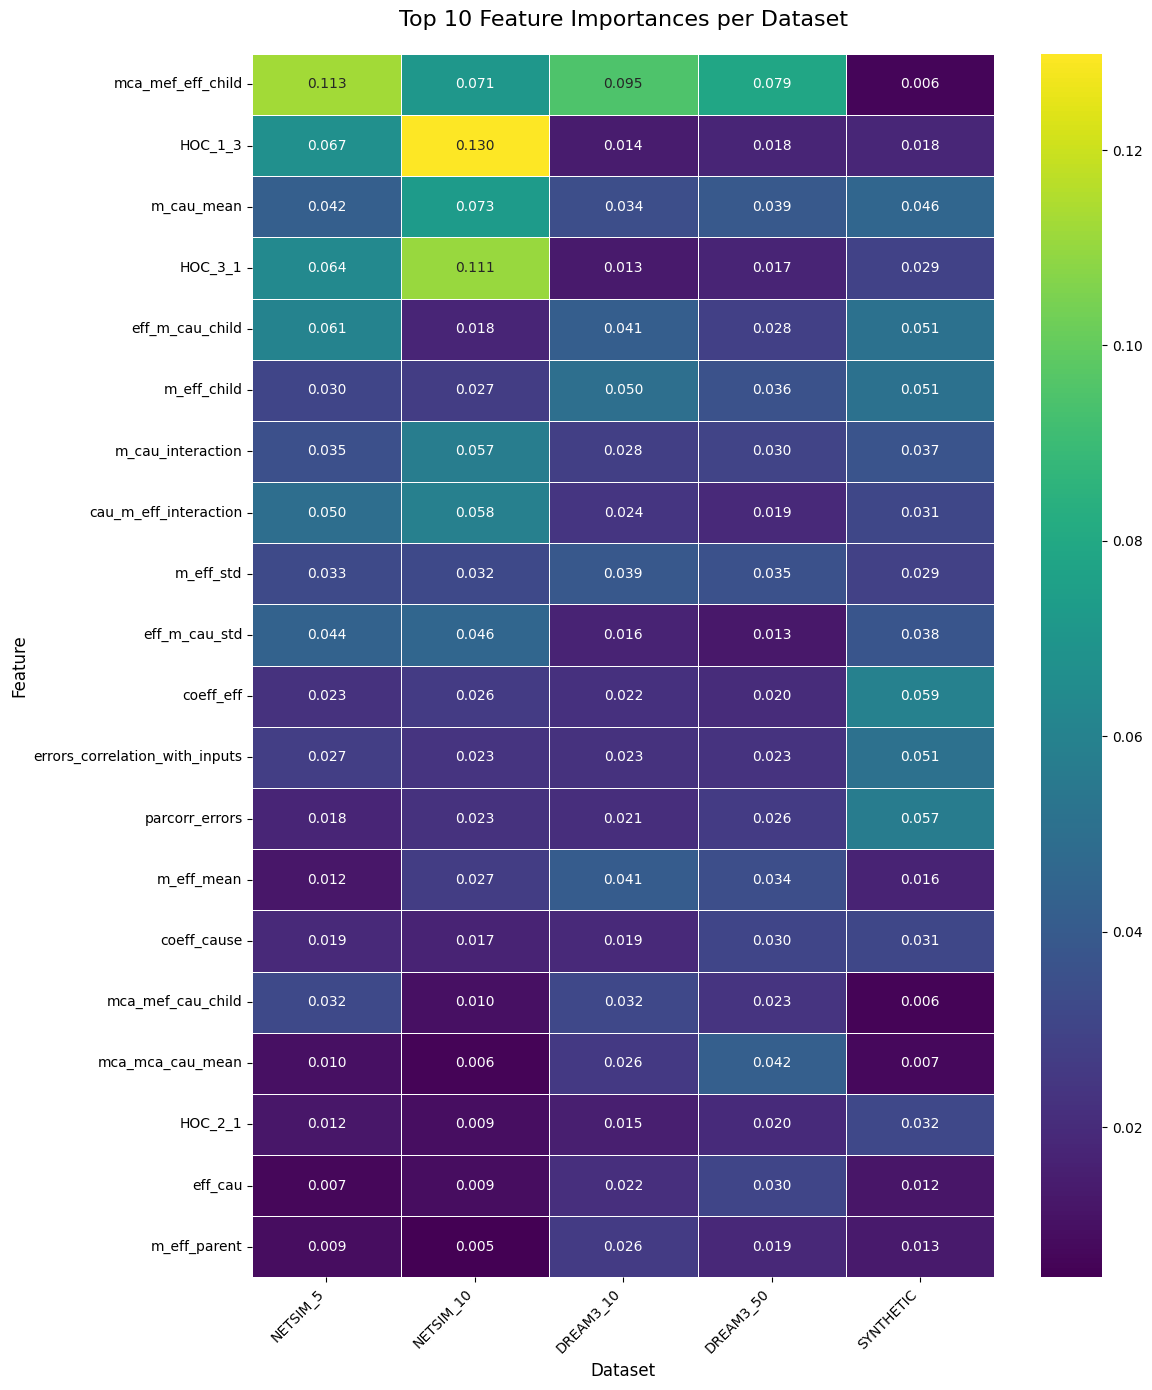

In [6]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier

# %%
# Dictionary mapping test set names to their file paths
all_tests_set = {
    'NETSIM_5': 'data/descriptors/descriptors_netsim_5.pkl',
    'NETSIM_10': 'data/descriptors/descriptors_netsim_10.pkl',
    'DREAM3_10': 'data/descriptors/descriptors_dream3_10.pkl',
    'DREAM3_50': 'data/descriptors/descriptors_dream3_50.pkl',
    'SYNTHETIC': 'data/descriptors/descriptors_df_test.pkl'
}

# Dictionary to store feature importances for each dataset
all_importances = {}

# --- Train a separate model for each dataset to get specific feature importances ---
for name, path in all_tests_set.items():
    print(f"Analyzing feature importances for: {name}...")
    
    # Load the dataset
    df = pd.read_pickle(path)
    
    # Fill NaNs with the mean of that specific dataset
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Prepare features and targets
    feature_cols = [col for col in df.columns 
                    if col not in ['graph_id', 'edge_source', 'edge_dest', 'is_causal']]
    
    X = df[feature_cols]
    y = df['is_causal']

    # Train a Balanced Random Forest model
    clf = BalancedRandomForestClassifier(
        n_estimators=50,
        random_state=42, 
        n_jobs=50,
        sampling_strategy='auto',  # Automatically balance the classes
        replacement=True,          # Allow replacement to ensure balanced sampling
        bootstrap=True,          # Use bootstrap sampling
    )
    clf.fit(X, y)

    # Store the feature importances in a pandas Series with feature names as the index
    importances_series = pd.Series(clf.feature_importances_, index=feature_cols)
    all_importances[name] = importances_series

# Combine all importance Series into a single DataFrame
importance_df = pd.DataFrame(all_importances)

# %%
# --- Select the top features for visualization ---

# Find the union of the top 10 features from each dataset
top_features = set()
for dataset_name in importance_df.columns:
    top_10 = importance_df[dataset_name].nlargest(10).index
    top_features.update(top_10)

# Filter the DataFrame to only include the overall top features
top_features_df = importance_df.loc[list(top_features)]

# Sort the features by their mean importance across all datasets for better visualization
top_features_df = top_features_df.loc[top_features_df.mean(axis=1).sort_values(ascending=False).index]


print("\n--- Top Feature Importances Across Datasets ---")
print(top_features_df)

# Save the results to a CSV file
top_features_df.to_csv('top_feature_importances_per_dataset.csv')
print("\nTop feature importance data saved to 'top_feature_importances_per_dataset.csv'")

# %%
# --- Visualize the results in a heatmap ---

plt.style.use('default')
plt.figure(figsize=(12, 14)) # Adjust size as needed based on the number of features

sns.heatmap(
    top_features_df, 
    annot=True,          # Show the importance scores on the heatmap
    fmt=".3f",           # Format numbers to 3 decimal places
    cmap='viridis',      # Color scheme
    linewidths=.5
)

plt.title('Top 10 Feature Importances per Dataset', fontsize=16, pad=20)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [1]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd 

In [2]:
all_tests_set = {'NETSIM_5':'data/descriptors/descriptors_netsim_5.pkl',
                'NETSIM_10':'data/descriptors/descriptors_netsim_10.pkl',
                'DREAM3_10':'data/descriptors/descriptors_dream3_10.pkl',
                'DREAM3_50':'data/descriptors/descriptors_dream3_50.pkl',
                'SYNTHETIC':'data/descriptors/descriptors_df_test.pkl'}

multiple_dfs = []
for name, path in all_tests_set.items():
    single_df = pd.read_pickle(path)
    multiple_dfs.append(single_df)

train_descriptors = pd.concat(multiple_dfs, ignore_index=True)
# Fill NaNs
train_descriptors.fillna(0, inplace=True)

# Prepare features and targets
feature_cols = [col for col in train_descriptors.columns 
                if col not in ['graph_id', 'edge_source', 'edge_dest', 'is_causal']]

X_train = train_descriptors[feature_cols]
y_train = train_descriptors['is_causal']

clf = BalancedRandomForestClassifier(n_estimators=500,random_state=42, n_jobs=50)
clf.fit(X_train, y_train)

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this

BalancedRandomForestClassifier(n_estimators=500, n_jobs=50, random_state=42)

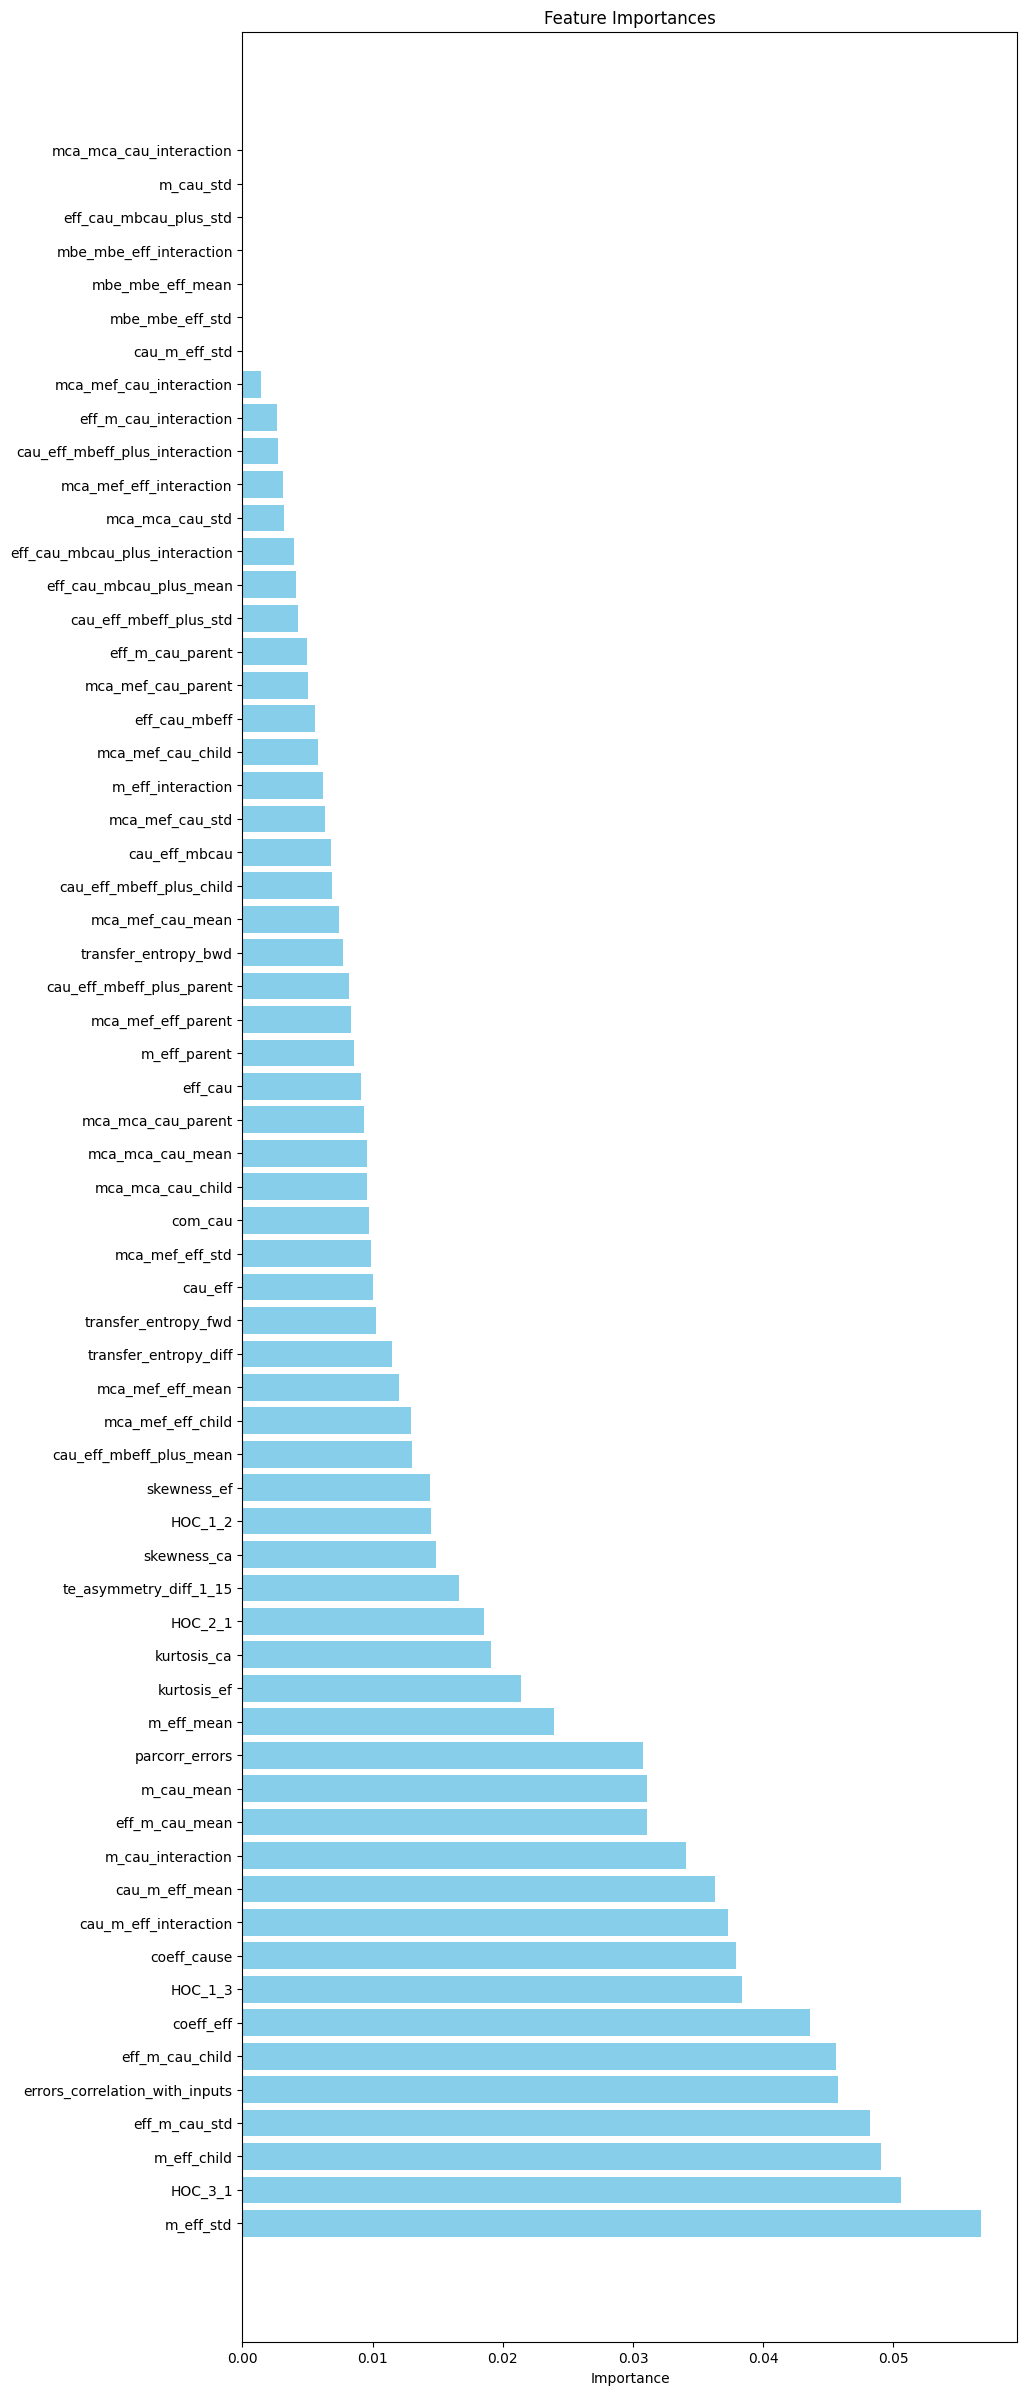

In [3]:
import matplotlib.pyplot as plt

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 30))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


In [ ]:
feature_importances.to_csv('feature_importances.csv', index=False)